In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.6'

# 回帰の例：住宅価格の予測

回帰では離散的なラベルではなく連続値を予測する。気象データの明日の気温や、ソフトウェアプロジェクトの完了する時間の予測など。

※ロジスティック回帰は分類アルゴリズムなので注意

## Boston Housingデータセット

1970年代中頃のボストン近郊での住宅価格の中央値を予測する。予測には犯罪発生率、地方財産税などを使用する。    
今までとは興味深い違いがある。データ点は506個と比較的少なく、404の訓練サンプルと102のテストサンプルに分割。入力データの特徴量（犯罪発生率など）はそれぞれ違う尺度をしよう。0〜1の値もあれば1〜12の値もあれば0〜100の値を取るものもある。

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

57344/57026 [==============================] - 0s 4us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)



13の特徴    


1. Per capita crime rate.
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940.
8. Weighted distances to five Boston employment centres.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13. % lower status of the population.


In [5]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

住宅価格は主に10000ドルから50000ドルの間。安いと思うなら1970年代のデータであることを思い出してください。これらの価格はインフレ率に合わせて調整されていない。

## データの準備

スケールの違いがあるのでベクとプラクティスとしては特徴量ごとの正規化する。列ごとに「特徴量の平均値を引き、標準偏差で割る」。特徴量の中心が0になり、標準偏差が1になる。

In [0]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

テストデータの正規化に使用される値は、訓練データを使って計算。データの正規化のような単純なものでテストデータを使って計算はしないほうがいい。

## ニューラルネットワークの構築


サンプル数が少ないので小さいモデルにする。一般的には訓練データが少なければ過学習になりやすい。小さいネットワークを使用することは、過学習を抑制する方法の１つ。

In [0]:
from keras import models
from keras import layers

#同じモデルを複数回インスタンス化する
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

最後の層のユニットは１ユニットで活性化関数がないので線形層。スカラー回帰の典型例。スカラー回帰は連続値を１つだけ予測する回帰。最終層を活性化関数sigmoidを入れた場合はネットワークは0から1の値を予測するものに制限される。線形層の場合はあらゆる範囲の値を予測する学習ができる。    

損失関数にmse 平均二乗誤差が広く知られてる。

## k分割交差検証によるアプローチの検証

データ点の数が少ない時は、検証データセットの分割方法によって検証スコアのバリアンすが高くなり、過学習にいたる。    
その場合のベストプラクティスはk分割交差検証(k-fold cross-validation)。    
k分割の交差検証はデータをk個に分割してk-1個で訓練し残りの1個でテスト、これを繰り返しスコアの平均を出す。


In [8]:
10 // 2

5

In [7]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # 検証データの準備：フォールドiのデータ
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 訓練データの準備：残りのフォールドのデータ
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # kerasモデルを構築
    model = build_model()
    # モデルをサイレントモードで適合 verbose=0
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    #モデル検証
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [10]:
all_scores

[2.858613155855991, 3.391531514649344, 3.3592295387003683, 3.6240799969965867]

In [11]:
np.mean(all_scores) #2.4にならないこともある

3.3083635515505727


コード実行のたびに検証スコアが2.1から2.9の間で変化している。それらの平均値2.4の方が信頼できる指標。この場合平均は2400ドル。



In [0]:
from keras import backend as K

# Some memory clean-up
K.clear_session()

In [13]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


全てのフォールドを対象にエポックごとのMAEスコアの平均を求める

In [0]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

プロットする

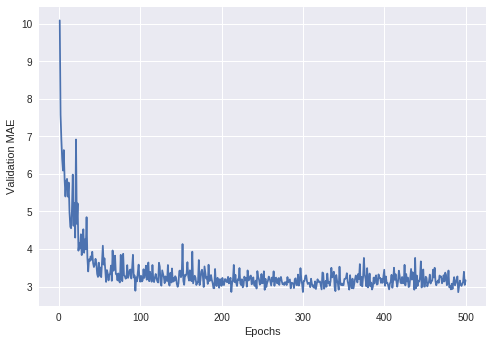

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

スケーリングの問題やバリアンスが高いせいでプロットを読んでも理解が少し難しいかもしれない。    

- 最初の10個のデータ点を省略。それらのデータ点は曲線の残りの部分とは異なる尺度に基づいている。    
- 各データ点をその手前にある点の指数移動平均に置き換えることで、滑らかな曲線がひける

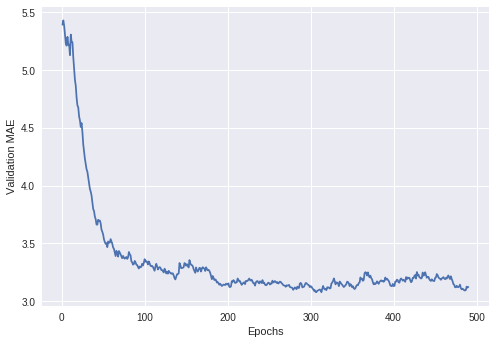

In [16]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor)) #ここ
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

このプロットから検証スコア MAEが80エポック後に大きく改善されていることがわかる。そのポイントを過ぎた後は過学習に陥ってる。    
モデルの他のパラメータのチューニングが完了したら、最適なパラメータと訓練データ全体を使って最終的なモデルの訓練をする。パラメータはエポック数、隠れ層のサイズも調整できるとあるが、今回エポック数を変更

In [17]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 602us/step


In [18]:
test_mae_score

6.687626950881061

依然として2,550ドルもずれている

# まとめ

- 二値分類、クラス分類、スカラー回帰を学んだ。    
- 次は機械学習の基礎    